In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import entropy

In [2]:

data = pd.read_csv('modified_data7.csv', encoding='cp1252')

# 필요없는 피처 날리기
data = data.drop("subbedOutTime", axis=1)
data = data.drop("position", axis=1)
data = data.drop("fantasyScore", axis=1)

# 포지션만 있고 세부 포지션 널값처리
# 'positionStringShort'의 널값이 있는 행 찾기
null_positions = data[data['positionStringShort'].isna()]

# 각 널값에 대해 처리
for index, row in null_positions.iterrows():
    # 현재 널값이 있는 행의 'name' 가져오기
    name = row['name']
    # 해당 'name'을 가진 모든 행에서 'positionStringShort'의 최빈값 찾기
    most_frequent_position = data[data['name'] == name]['positionStringShort'].mode()[0]
    # 널값 채우기
    data.at[index, 'positionStringShort'] = most_frequent_position

data = data.drop("name", axis=1)
# rating 널값 제거, 개수가 매우적어 없는거만 제거
data = data.dropna(subset=["rating"])

# x , y 나누기
data_x = data.drop("rating", axis=1)
data_y = data["rating"]

# 학습, 테스트 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

# 'positionStringShort'와 'positionRow' 열 선택
x_train_cat = x_train[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder = OneHotEncoder()
# 원-핫 인코딩 적용
x_train_cat_1hot = cat_encoder.fit_transform(x_train_cat)
# positionStringShort, positionRow은 카테고리컬
x_train_num = x_train.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features = x_train_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled = scaler.fit_transform(numeric_features)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns,
                                          index=x_train_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df = numeric_features_scaled_df.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled = x_train_num.copy()
data_num_scaled[numeric_features.columns] = numeric_features_scaled_df

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_train_cat_1hot_df = pd.DataFrame(x_train_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(),
                                   index=x_train.index)

# 불리언 타입의 데이터만 선택
bool_features = x_train_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_train_prepared = pd.concat([data_num_scaled, bool_features, x_train_cat_1hot_df], axis=1)


In [3]:
x_test, y_test

# x_test, y_test


# 'positionStringShort'와 'positionRow' 열 선택
x_test_cat = x_test[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder2 = OneHotEncoder()
# 원-핫 인코딩 적용
x_test_cat_1hot = cat_encoder2.fit_transform(x_test_cat)

# positionStringShort, positionRow은 카테고리컬
x_test_num = x_test.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features2 = x_test_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler2 = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled2 = scaler.transform(numeric_features2)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df2 = pd.DataFrame(numeric_features_scaled2, columns=numeric_features2.columns,
                                          index=x_test_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df2 = numeric_features_scaled_df2.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled2 = x_test_num.copy()
data_num_scaled2[numeric_features2.columns] = numeric_features_scaled_df2

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_test_cat_1hot_df = pd.DataFrame(x_test_cat_1hot.toarray(), columns=cat_encoder2.get_feature_names_out(),
                                   index=x_test.index)

# 불리언 타입의 데이터만 선택
bool_features2 = x_test_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared = pd.concat([data_num_scaled2, bool_features2, x_test_cat_1hot_df], axis=1)
# 'positionStringShort'와 'positionRow' 열 선택
x_test_cat = x_test[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder2 = OneHotEncoder()
# 원-핫 인코딩 적용
x_test_cat_1hot = cat_encoder2.fit_transform(x_test_cat)

# positionStringShort, positionRow은 카테고리컬
x_test_num = x_test.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features2 = x_test_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler2 = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled2 = scaler.transform(numeric_features2)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df2 = pd.DataFrame(numeric_features_scaled2, columns=numeric_features2.columns,
                                          index=x_test_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df2 = numeric_features_scaled_df2.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled2 = x_test_num.copy()
data_num_scaled2[numeric_features2.columns] = numeric_features_scaled_df2

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_test_cat_1hot_df = pd.DataFrame(x_test_cat_1hot.toarray(), columns=cat_encoder2.get_feature_names_out(),
                                   index=x_test.index)

# 불리언 타입의 데이터만 선택
bool_features2 = x_test_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared = pd.concat([data_num_scaled2, bool_features2, x_test_cat_1hot_df], axis=1)

In [4]:
tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(x_train_prepared, y_train)

DecisionTreeRegressor(max_depth=3)

In [10]:
y_pred = tree_reg.predict(x_test_prepared) 
print(x_test_prepared.shape)



mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE_3:", rmse)
# 성능 평가: MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:_3", mae)

print(y_pred[0:10])
print(y_test[0:10])

(2172, 58)
RMSE_3: 0.6443460702652377
MAE:_3 0.49320539668235136
[6.48470191 7.00797861 7.00797861 7.00797861 7.78314607 6.48470191
 7.00797861 7.00797861 7.00797861 7.00797861]
5299     4.7
2073     6.7
8210     6.2
7092     6.5
10504    7.5
9003     6.7
1434     7.3
4535     7.5
3031     6.7
4154     5.1
Name: rating, dtype: float64


7.0301710378900655
7.013271320685217


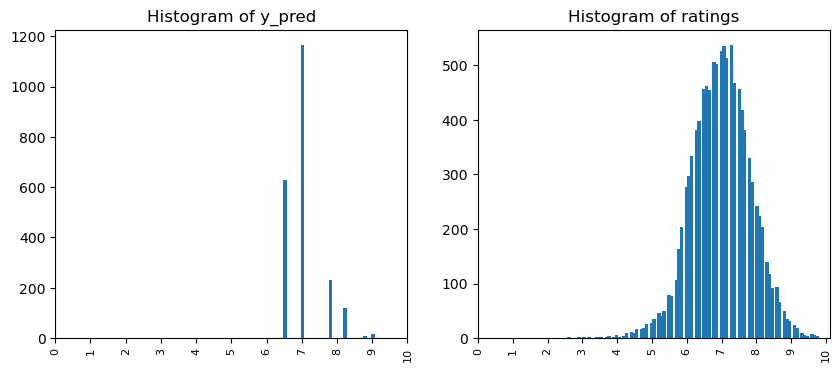

In [11]:
# y_pred에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of y_pred')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(y_pred.mean())
print(data['rating'].mean())

In [6]:
rnd_for = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_for.fit(x_train_prepared, y_train)

RandomForestRegressor(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [7]:
rnd_for_pred = rnd_for.predict(x_test_prepared) 



mse_rnd = mean_squared_error(y_test, rnd_for_pred)
rmse_rnd = np.sqrt(mse_rnd)
print("RMSE_rnd:", rmse_rnd)
# 성능 평가: MAE
mae_rnd = mean_absolute_error(y_test, rnd_for_pred)
print("MAE:_rnd", mae_rnd)

# 첫 10개의 예측값과 실제값 출력
print("Predictions:", y_pred[:10])
print("Actual:", y_test.iloc[:10].tolist())

RMSE_rnd: 0.5783584966214115
MAE:_rnd 0.4310638761702005
Predictions: [6.48470191 7.00797861 7.00797861 7.00797861 7.78314607 6.48470191
 7.00797861 7.00797861 7.00797861 7.00797861]
Actual: [4.7, 6.7, 6.2, 6.5, 7.5, 6.7, 7.3, 7.5, 6.7, 5.1]


7.030008827112255
7.013271320685217


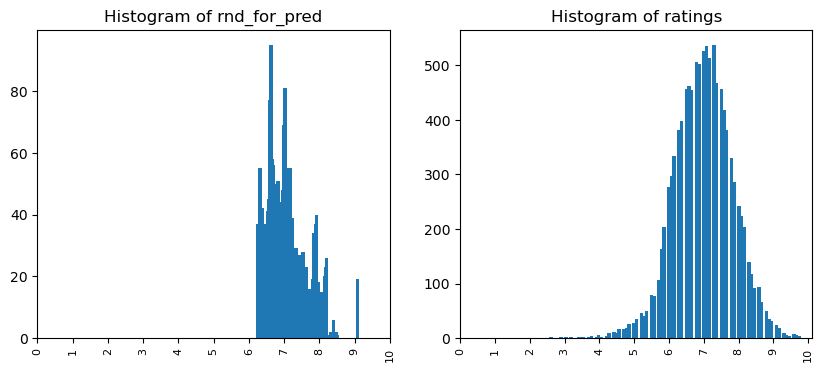

In [8]:
# rnd_for_pred에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(rnd_for_pred, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of rnd_for_pred')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(rnd_for_pred.mean())
print(data['rating'].mean())

In [13]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(rnd_for_pred, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence


3.090167809343968

In [8]:
# RandomForestRegressor의 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': randint(100, 1000),  # 트리의 개수
    'max_features': ['auto', 'sqrt', 'log2'],  # 최대 특성 개수
    'max_depth': randint(5, 50),  # 최대 깊이
    'min_samples_split': randint(2, 20),  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': randint(1, 20),  # 리프 노드의 최소 샘플 수
    'bootstrap': [True, False]  # 부트스트랩 샘플링 사용 여부
}

# RandomForestRegressor 객체 생성
rf = RandomForestRegressor()

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, 
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# RandomizedSearchCV 실행
random_search.fit(x_train_prepared, y_train)

# 최적의 파라미터와 점수 출력
print("Best parameters:", random_search.best_params_)
print("Best score (RMSE):", np.sqrt(-random_search.best_score_))

'''
코랩 결과
Best parameters: {'bootstrap': True, 'max_depth': 47, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 259}
Best score (RMSE): 0.54351468409041

'''


KeyboardInterrupt

